In [1]:
# Standard libraries
import numpy as np
import h5py
import matplotlib.pyplot as plt
from ipywidgets import interactive

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")
pwd_mat = os.path.join(os.path.join(path2p, "data/"), "sim_ds_mat")
pwd_h5 = os.path.join(os.path.join(path2p, "data/"), "sim_ds_h5")

sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_mat
from signal_lib import downsample
from corr_lib import sprMat
from qt_wrapper import gui_fnames
#from idtxl_wrapper import idtxlResultsParse

Appended library directory /home/alyosha/work/nest-mesoscopic-metric-test/codes/lib


## Processing single point data

In [2]:
def getData(fname):
    print("Reading file", fname)
    filename = os.path.join(pwd_h5, os.path.join("real_data", fname))
    h5f = h5py.File(filename, "r")
    TE = np.copy(h5f['results']['TE_table'])
    lag = np.copy(h5f['results']['delay_table'])
    p = np.copy(h5f['results']['p_table'])
    h5f.close()
    return (TE, lag, p)

def getStatistics(basenames):
    stat = {}
    
    # By Analysis type
    stat['isAnalysis'] = {}
    stat['isAnalysis']['swipe'] = np.array(["swipe" in name for name in basenames], dtype=int)
    stat['isAnalysis']['range'] = np.array(["range" in name for name in basenames], dtype=int)
    stat['isAnalysis']['all'] = stat['isAnalysis']['swipe'] + stat['isAnalysis']['range'] == 0

    # Determine if file uses GO, NOGO, or all
    stat['isTrial'] = {}
    stat['isTrial']['GO'] = np.array(["iGO" in name for name in basenames], dtype=int)
    stat['isTrial']['NOGO'] = np.array(["iNOGO" in name for name in basenames], dtype=int)
    stat['isTrial']['ALL']  = stat['isTrial']['GO'] + stat['isTrial']['NOGO'] == 0

    # Determine range types
    stat['isRange'] = {}
    stat['isRange']['CUE'] = np.array(["CUE" in name for name in basenames], dtype=int)
    stat['isRange']['TEX'] = np.array(["TEX" in name for name in basenames], dtype=int)
    stat['isRange']['LIK'] = np.array(["LIK" in name for name in basenames], dtype=int)
    stat['isRange']['none'] = stat['isRange']['CUE'] + stat['isRange']['TEX'] + stat['isRange']['LIK'] == 0

    # Determine which method was used
    stat['isMethod'] = {}
    stat['isMethod']['BTE'] = np.array(["BivariateTE" in name for name in basenames], dtype=int)
    stat['isMethod']['MTE'] = np.array(["MultivariateTE" in name for name in basenames], dtype=int)

    # Determine mouse which was used
    stat['mouse_names'] = ["_".join(name.split('_')[:2]) for name in basenames]
    print("By Analysis :::", {k: np.sum(v) for k,v in stat['isAnalysis'].items()})
    print("By Trial    :::", {k: np.sum(v) for k,v in stat['isTrial'].items()})
    print("By Range    :::", {k: np.sum(v) for k,v in stat['isRange'].items()})
    print("By Method   :::", {k: np.sum(v) for k,v in stat['isMethod'].items()})
    print("By Mouse    :::", {k: stat['mouse_names'].count(k) for k in set(stat['mouse_names'])})
    
    return stat

def getTitlesAndIndices(stat, mouse, trials, methods, analysis_type, ranges=[None]):
    rez = []
    isCorrectMouse = np.array([mname == mouse for mname in stat['mouse_names']], dtype=int)
    for trial in trials:
        for method in methods:
            for rng in ranges:
                title = '_'.join([mouse, analysis_type, trial, method])
                select = np.copy(isCorrectMouse)
                select += stat['isAnalysis'][analysis_type]
                select += stat['isTrial'][trial]
                select += stat['isMethod'][method]
                test = 4
                if rng is not None:
                    title+='_'+rng
                    test+=1
                    select += stat['isRange'][rng]
                rez.append((title, select == test))
    return rez

In [4]:
datafilesets = []
basenamesets = []
statistics = []

# GUI: Select videos for training
pwd_tmp = "./"
datafilenames = None
while datafilenames != ['']:
    datafilenames = gui_fnames("IDTXL swipe result files...", directory=pwd_tmp, filter="HDF5 Files (*.h5)")
    if datafilenames != ['']:
        print("Total user files in dataset", len(datafilesets), "is", len(datafilenames))   
        
        pwd_tmp = os.path.dirname(datafilenames[0])  # Next time choose from parent folder
        datafilesets += [np.array(datafilenames)]
        basenamesets += [np.array([os.path.basename(name) for name in datafilenames])]
        statistics += [getStatistics(basenamesets[-1])]
        
print('Selecting files Done, reading...')
datasets = [np.array([getData(fname) for fname in fnames]) for fnames in datafilesets]

Total user files in dataset 0 is 52
By Analysis ::: {'swipe': 52, 'range': 0, 'all': 0}
By Trial    ::: {'GO': 26, 'NOGO': 26, 'ALL': 0}
By Range    ::: {'CUE': 0, 'TEX': 0, 'LIK': 0, 'none': 52}
By Method   ::: {'BTE': 26, 'MTE': 26}
By Mouse    ::: {'mtp_15': 52}
Total user files in dataset 1 is 52
By Analysis ::: {'swipe': 52, 'range': 0, 'all': 0}
By Trial    ::: {'GO': 26, 'NOGO': 26, 'ALL': 0}
By Range    ::: {'CUE': 0, 'TEX': 0, 'LIK': 0, 'none': 52}
By Method   ::: {'BTE': 26, 'MTE': 26}
By Mouse    ::: {'mtp_15': 52}
Total user files in dataset 2 is 42
By Analysis ::: {'swipe': 42, 'range': 0, 'all': 0}
By Trial    ::: {'GO': 22, 'NOGO': 20, 'ALL': 0}
By Range    ::: {'CUE': 0, 'TEX': 0, 'LIK': 0, 'none': 42}
By Method   ::: {'BTE': 21, 'MTE': 21}
By Mouse    ::: {'mtp_15': 42}
Selecting files Done, reading...
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/subsample_delay_2_window_6/mtp_15_2018_05_16_a_iGO_BivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/

Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/subsample_delay_5_window_6/mtp_15_2018_05_17_a_iGO_BivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/subsample_delay_5_window_6/mtp_15_2018_05_17_a_iGO_MultivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/subsample_delay_5_window_6/mtp_15_2018_05_17_a_iNOGO_BivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/subsample_delay_5_window_6/mtp_15_2018_05_17_a_iNOGO_MultivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/subsample_delay_5_window_6/mtp_15_2018_05_18_a_iGO_BivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/subsample_delay_5_window_6/mtp_15_2018_05_18_a_iGO_MultivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/subsample_delay_5_window_6/mtp_15_2018_05_18_a_iNOGO_BivariateTE_swipe.h5
Reading file /mnt/hifo_scr

Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/raw_delay_2_window_10/mtp_15_2018_05_19_a_iNOGO_BivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/raw_delay_2_window_10/mtp_15_2018_05_19_a_iNOGO_MultivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/raw_delay_2_window_10/mtp_15_2018_05_22_a_iGO_BivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/raw_delay_2_window_10/mtp_15_2018_05_22_a_iGO_MultivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/raw_delay_2_window_10/mtp_15_2018_05_22_a_iNOGO_BivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/raw_delay_2_window_10/mtp_15_2018_05_22_a_iNOGO_MultivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_idtxl/raw_delay_2_window_10/mtp_15_2018_05_23_a_iGO_BivariateTE_swipe.h5
Reading file /mnt/hifo_scratch1/Yaro/TE_from_Aleksejs/data_

## Swipe Analysis

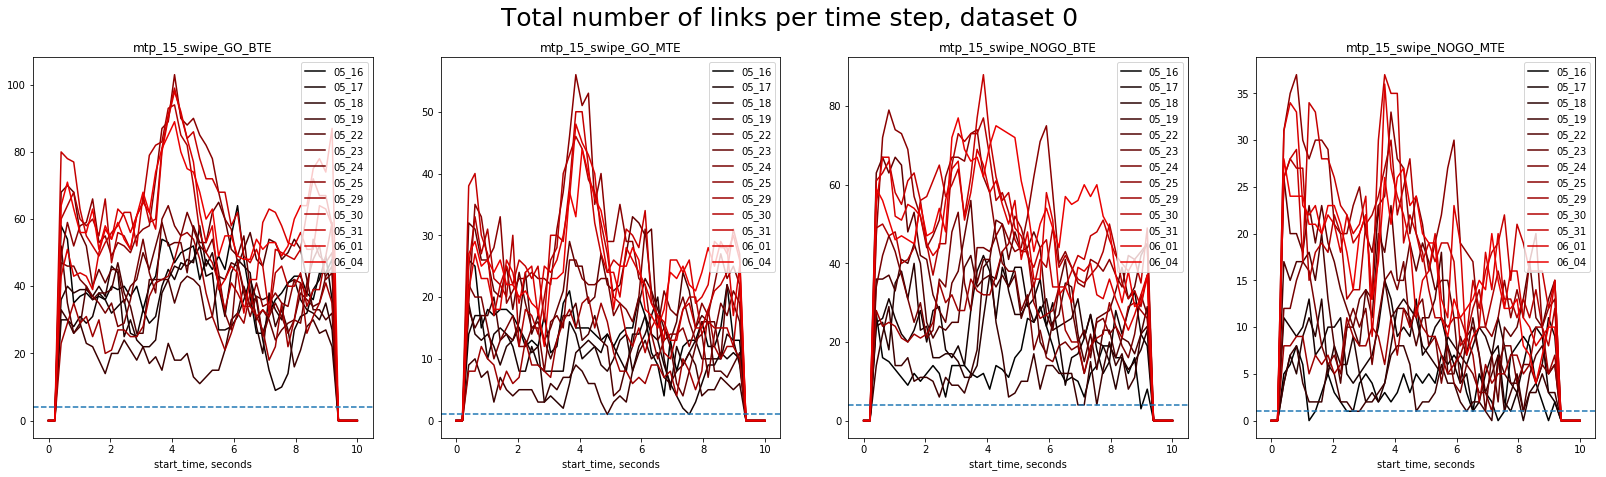

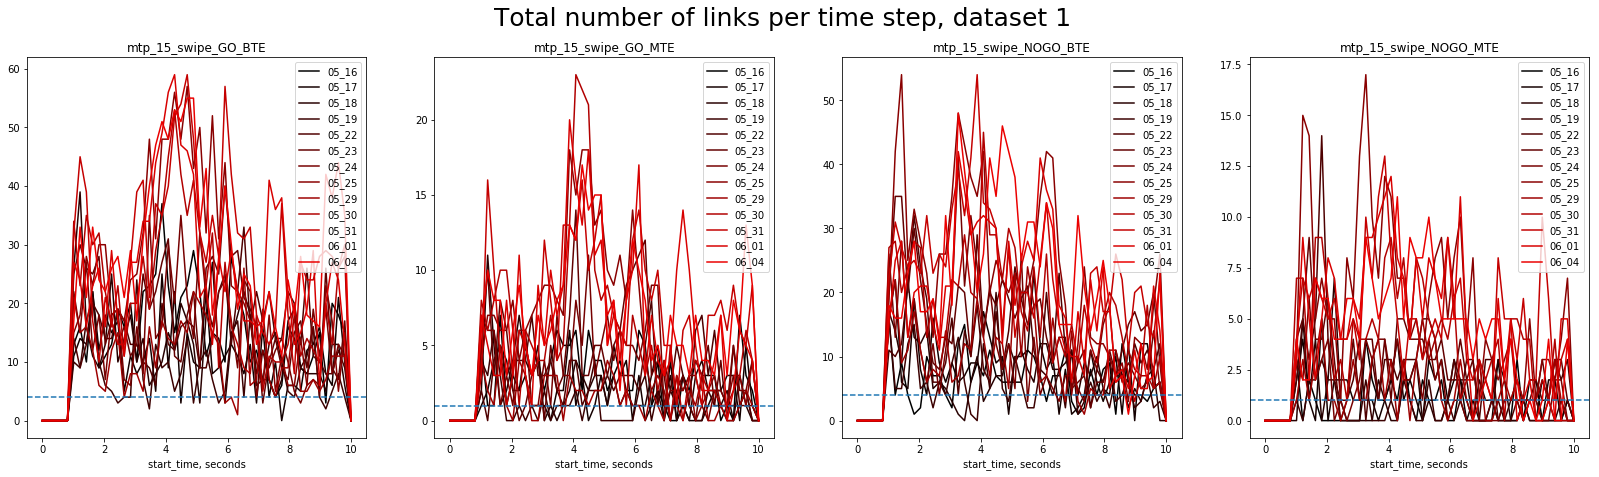

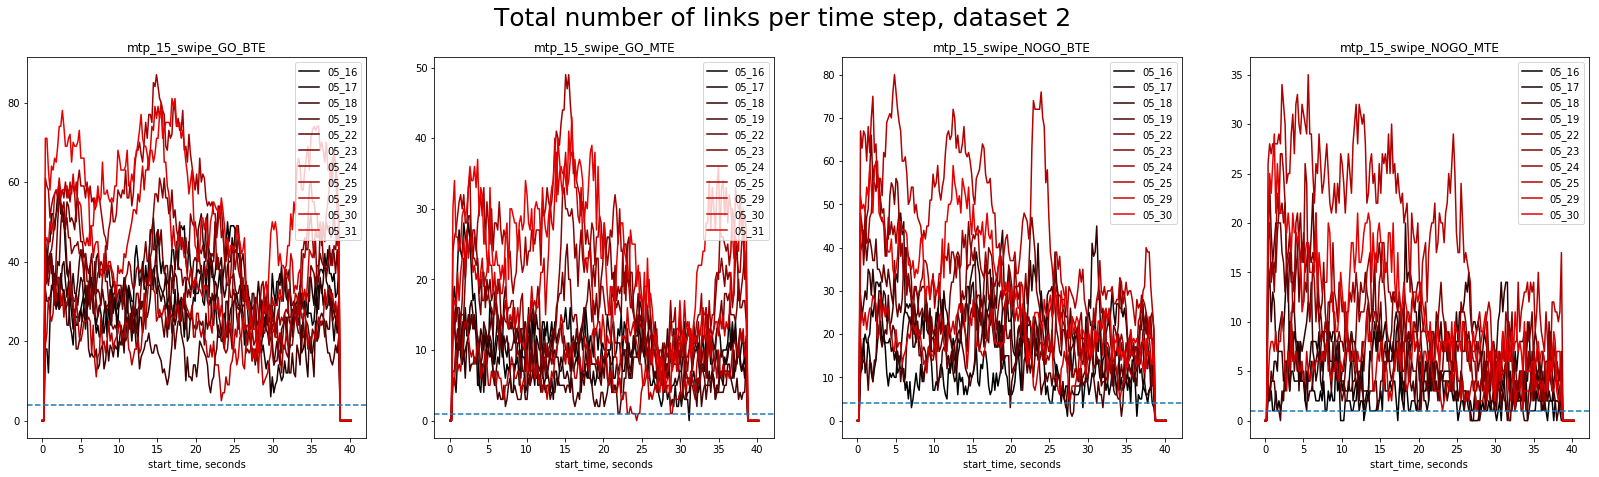

In [5]:
#################################
# time : Total Number of links
#################################

for iDataSet, (basenames, stat) in enumerate(zip(basenamesets, statistics)):
    tflist = getTitlesAndIndices(stat, 'mtp_15', ["GO","NOGO"], ["BTE","MTE"], "swipe")
    nPlots = len(tflist)

    fig, ax = plt.subplots(nrows=1, ncols=nPlots, figsize=(7*nPlots, 7))
    fig.suptitle('Total number of links per time step, dataset '+str(iDataSet), fontsize=25)

    for idxPlot, (pTitle, idxs_ths) in enumerate(tflist):
        nFiles = np.sum(idxs_ths)
        for idxFile, (data, basename) in enumerate(zip(datasets[iDataSet][idxs_ths], basenames[idxs_ths])):
            te, lag, p = data

            times = 0.2 * np.linspace(0, te.shape[2], te.shape[2])
            totalConnPerTime = [np.sum(1-np.isnan(te[:,:,i]).astype(int)) for i in range(te.shape[2])]

            ax[idxPlot].plot(times, totalConnPerTime, label=basename[12:17], color=((idxFile / nFiles), 0, 0))

        ax[idxPlot].set_title(pTitle)
        ax[idxPlot].axhline(y=4 if "BTE" in pTitle else 1, linestyle="--")
        ax[idxPlot].set_xlabel("start_time, seconds")
        ax[idxPlot].legend()

In [ ]:
#################################
# Degree Distribution
#################################
'''
  For each dataset, for each file, for each param combination
'''

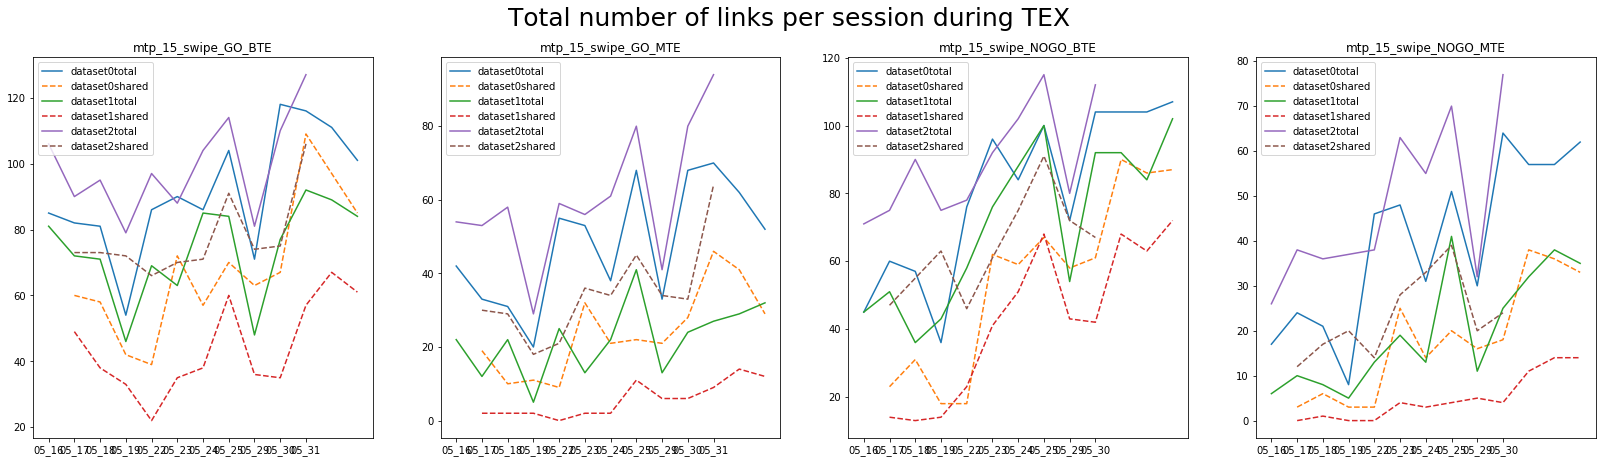

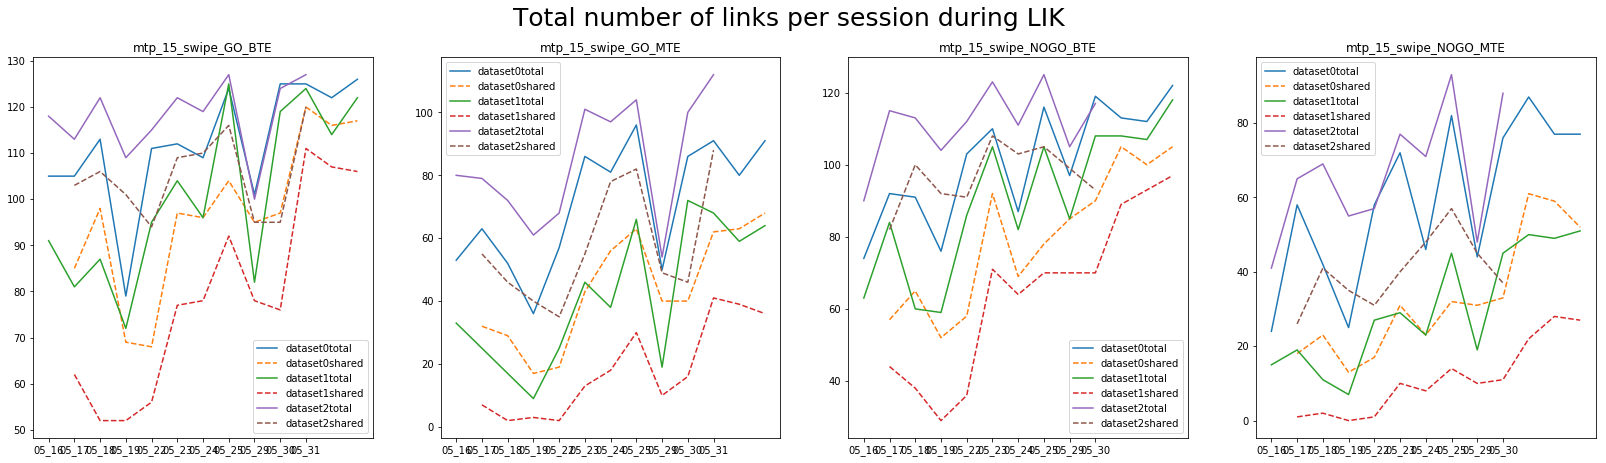

In [6]:
#################################
# Session : Total number of links
#################################
ranges_sec = {'TEX' : (2.0, 3.5), 'LIK' : (3.5, 6.0)}

for rng_name, rng_sec in ranges_sec.items():
    fig, ax = plt.subplots(nrows=1, ncols=nPlots, figsize=(7*nPlots, 7))
    fig.suptitle('Total number of links per session during '+rng_name, fontsize=25)
    
    for iDataSet, (basenames, stat) in enumerate(zip(basenamesets, statistics)):
        tflist = getTitlesAndIndices(stat, 'mtp_15', ["GO","NOGO"], ["BTE","MTE"], "swipe")

        for idxPlot, (pTitle, idxs_ths) in enumerate(tflist):
            nFiles = np.sum(idxs_ths)
            atLeast1ConnPerSession = []
            for idxFile, (data, basename) in enumerate(zip(datasets[iDataSet][idxs_ths], basenames[idxs_ths])):
                te, lag, p = data
                
                N_TIMES = te.shape[2]
                rng = np.round((np.array(rng_sec) / 10.0 * N_TIMES)).astype(int)
                te_rng = te[:,:,rng[0]:rng[1]]
                atLeast1ConnPerSession += [(np.sum(1-np.isnan(te_rng).astype(int), axis=2) > 0).astype(int)]
                
            totalConnPerSession = [np.sum(c) for c in atLeast1ConnPerSession]
            sharedConn = [np.nan] + [np.sum(atLeast1ConnPerSession[idxFile-1] + atLeast1ConnPerSession[idxFile] == 2) for idxFile in range(1, nFiles)]

            ax[idxPlot].plot(totalConnPerSession, label='dataset'+str(iDataSet)+'total')
            ax[idxPlot].plot(sharedConn, '--', label='dataset'+str(iDataSet)+'shared')
            ax[idxPlot].set_title(pTitle)
            ax[idxPlot].set_xticks(list(range(np.sum(idxs_ths))))
            ax[idxPlot].set_xticklabels([bname[12:17] for bname in basenames[idxs_ths]])
            ax[idxPlot].legend()

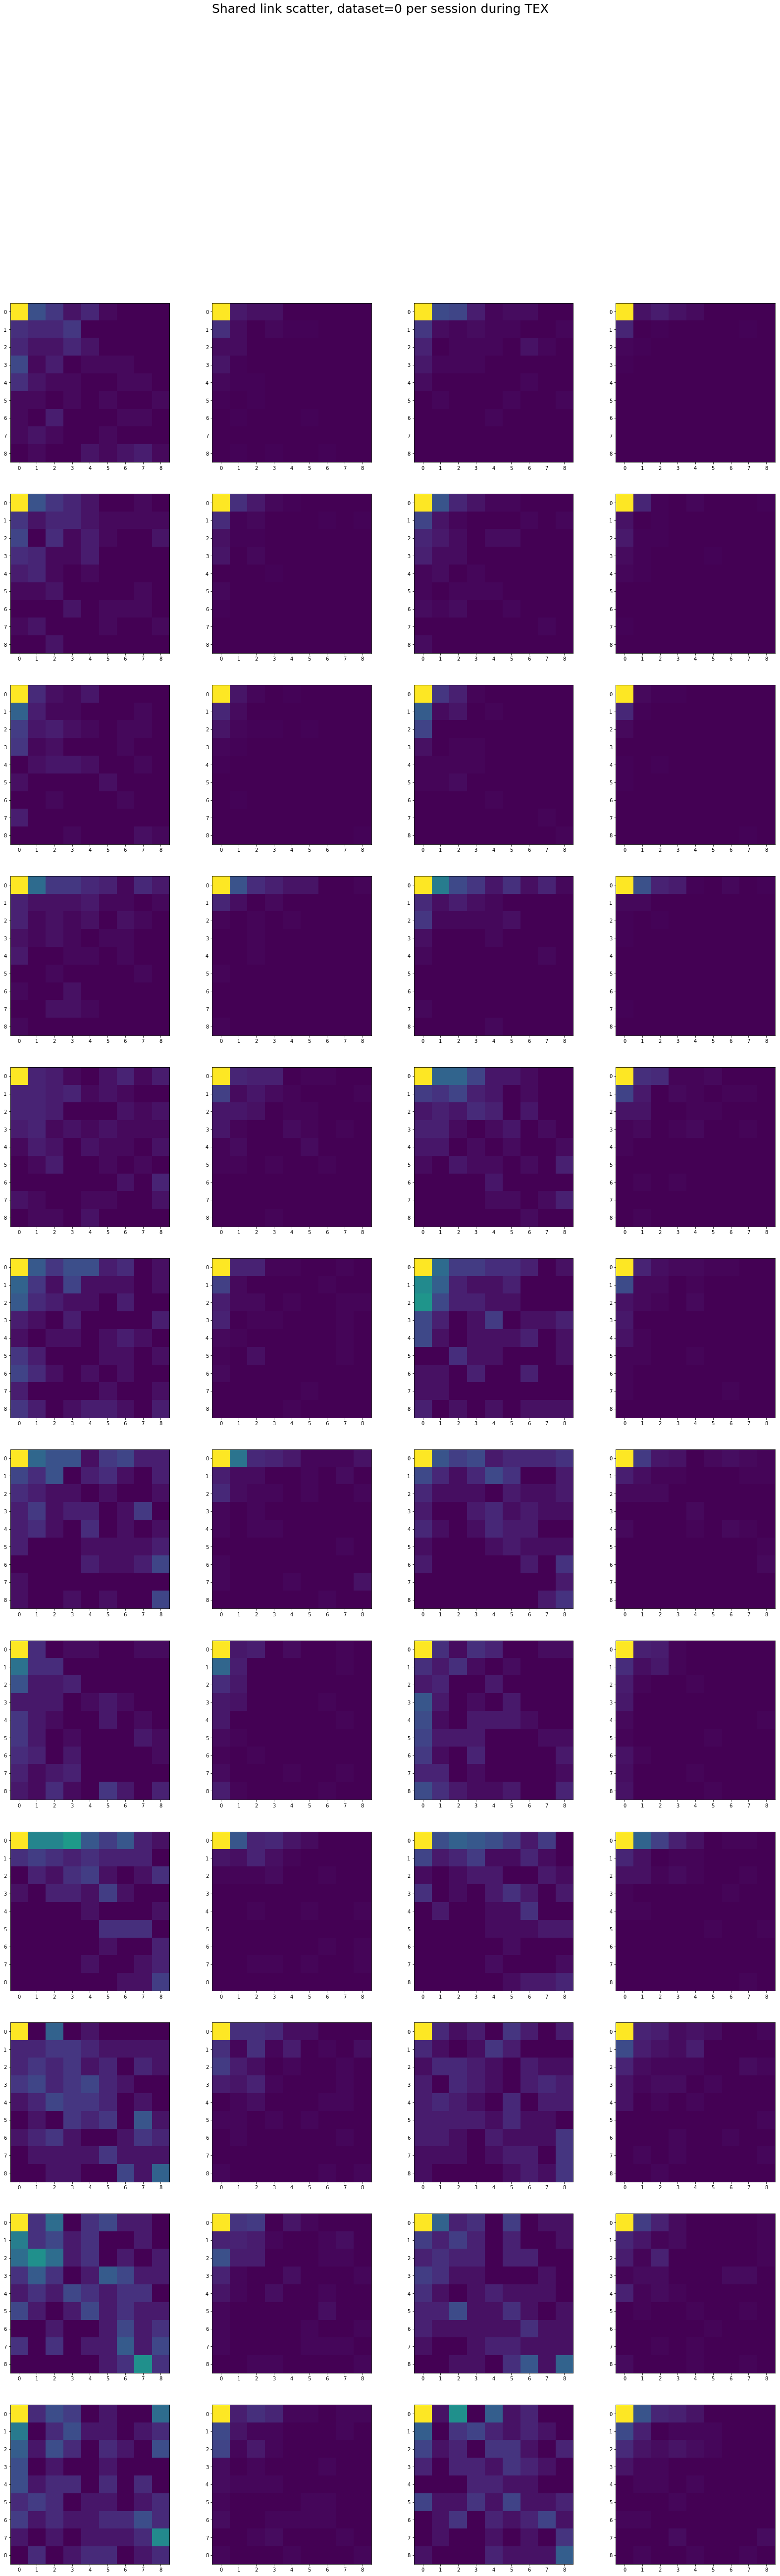

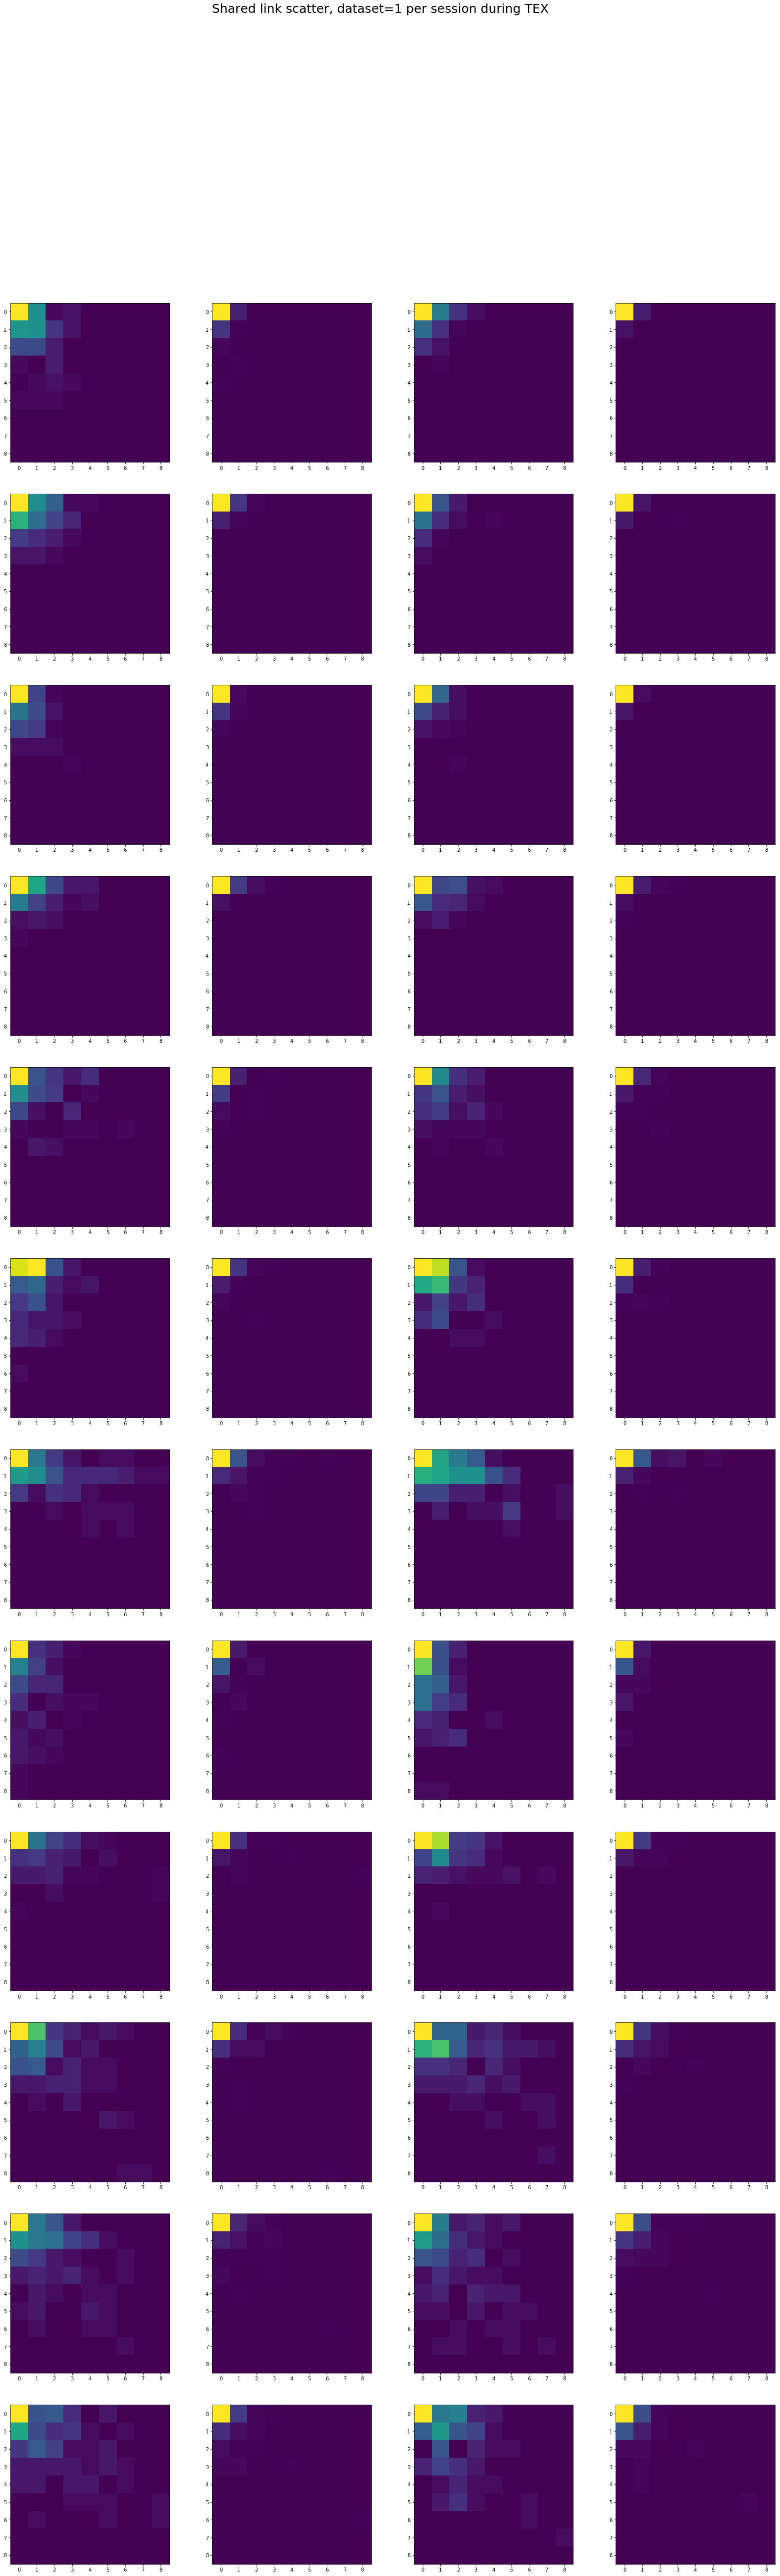

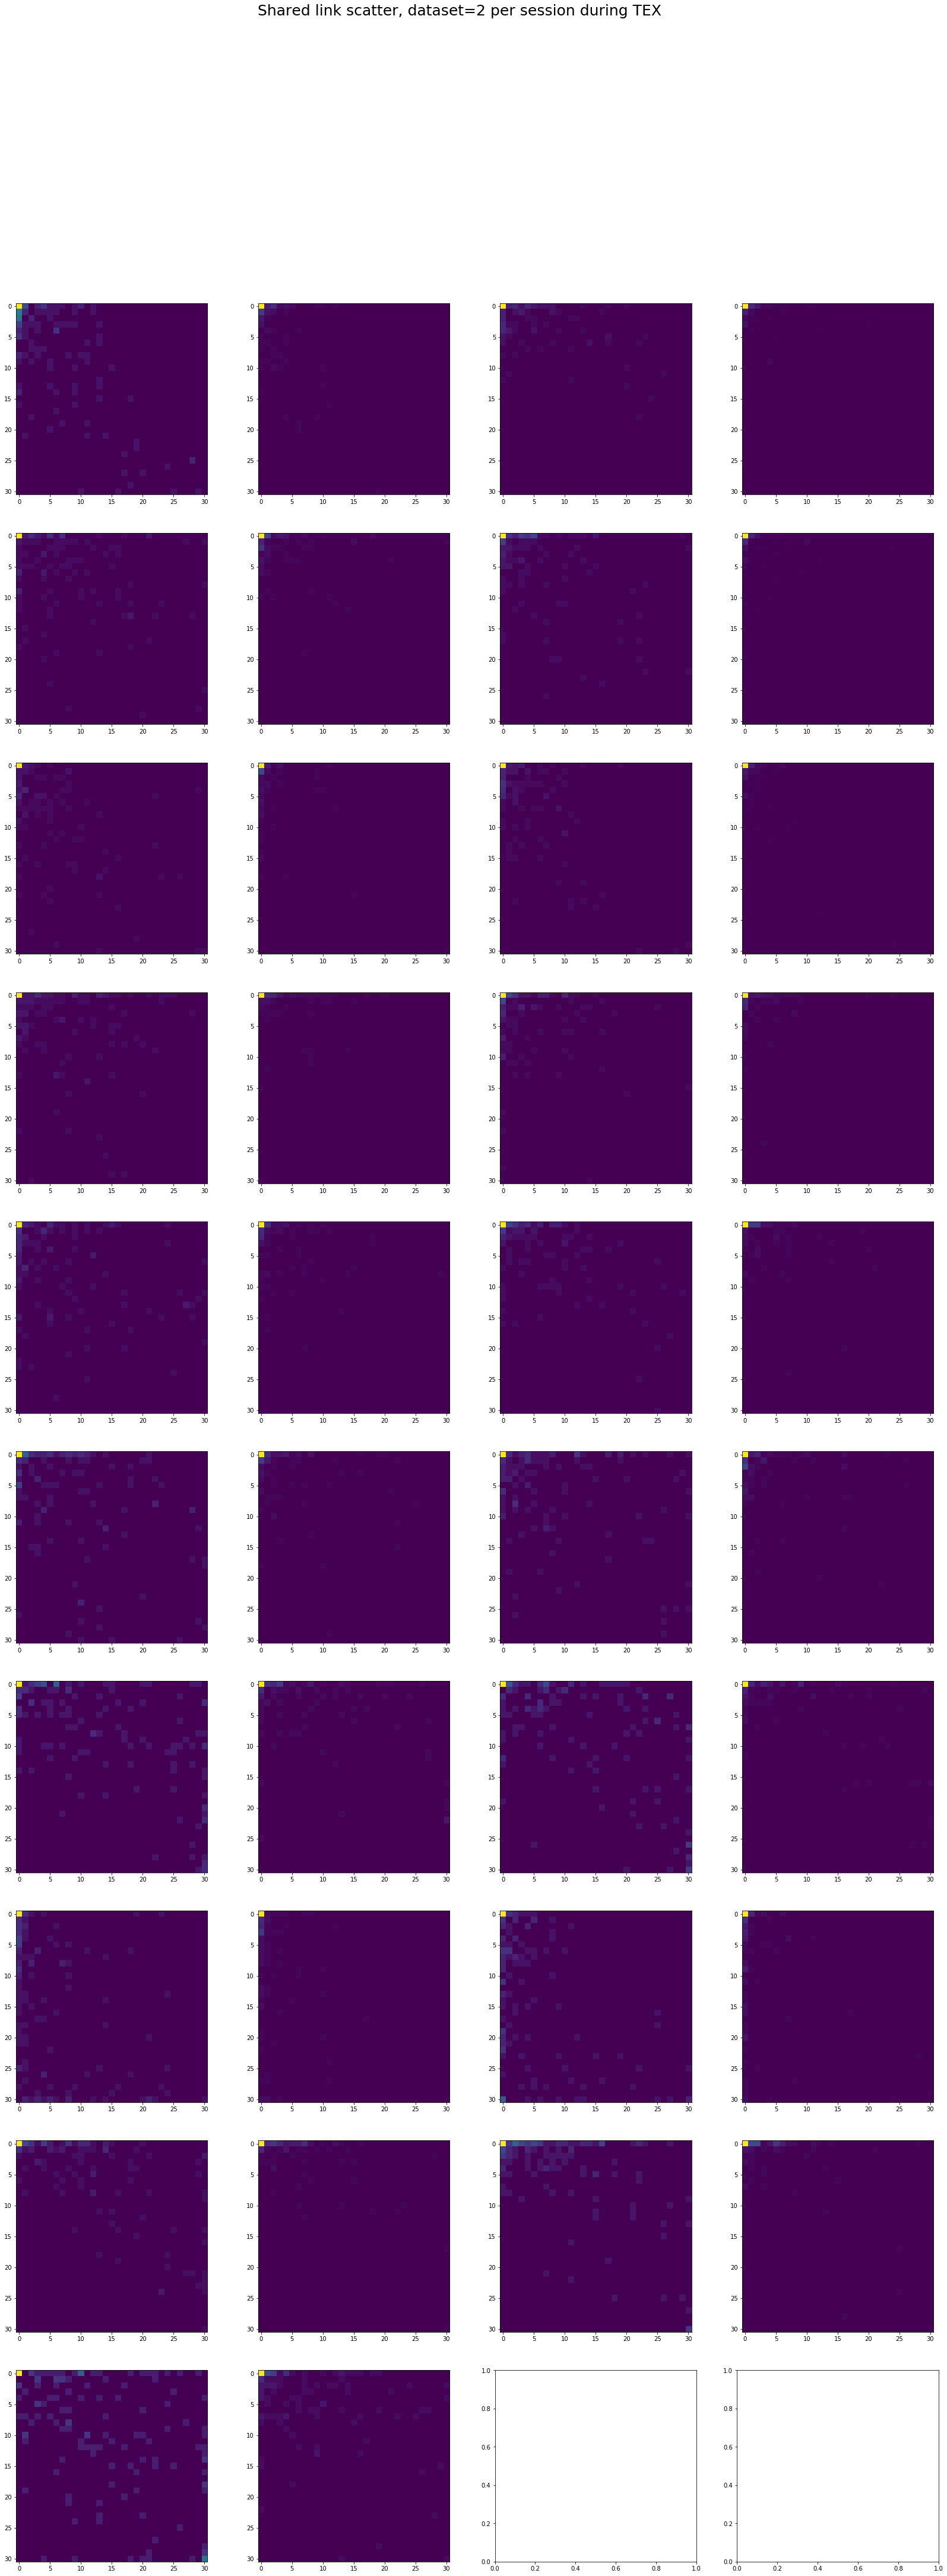

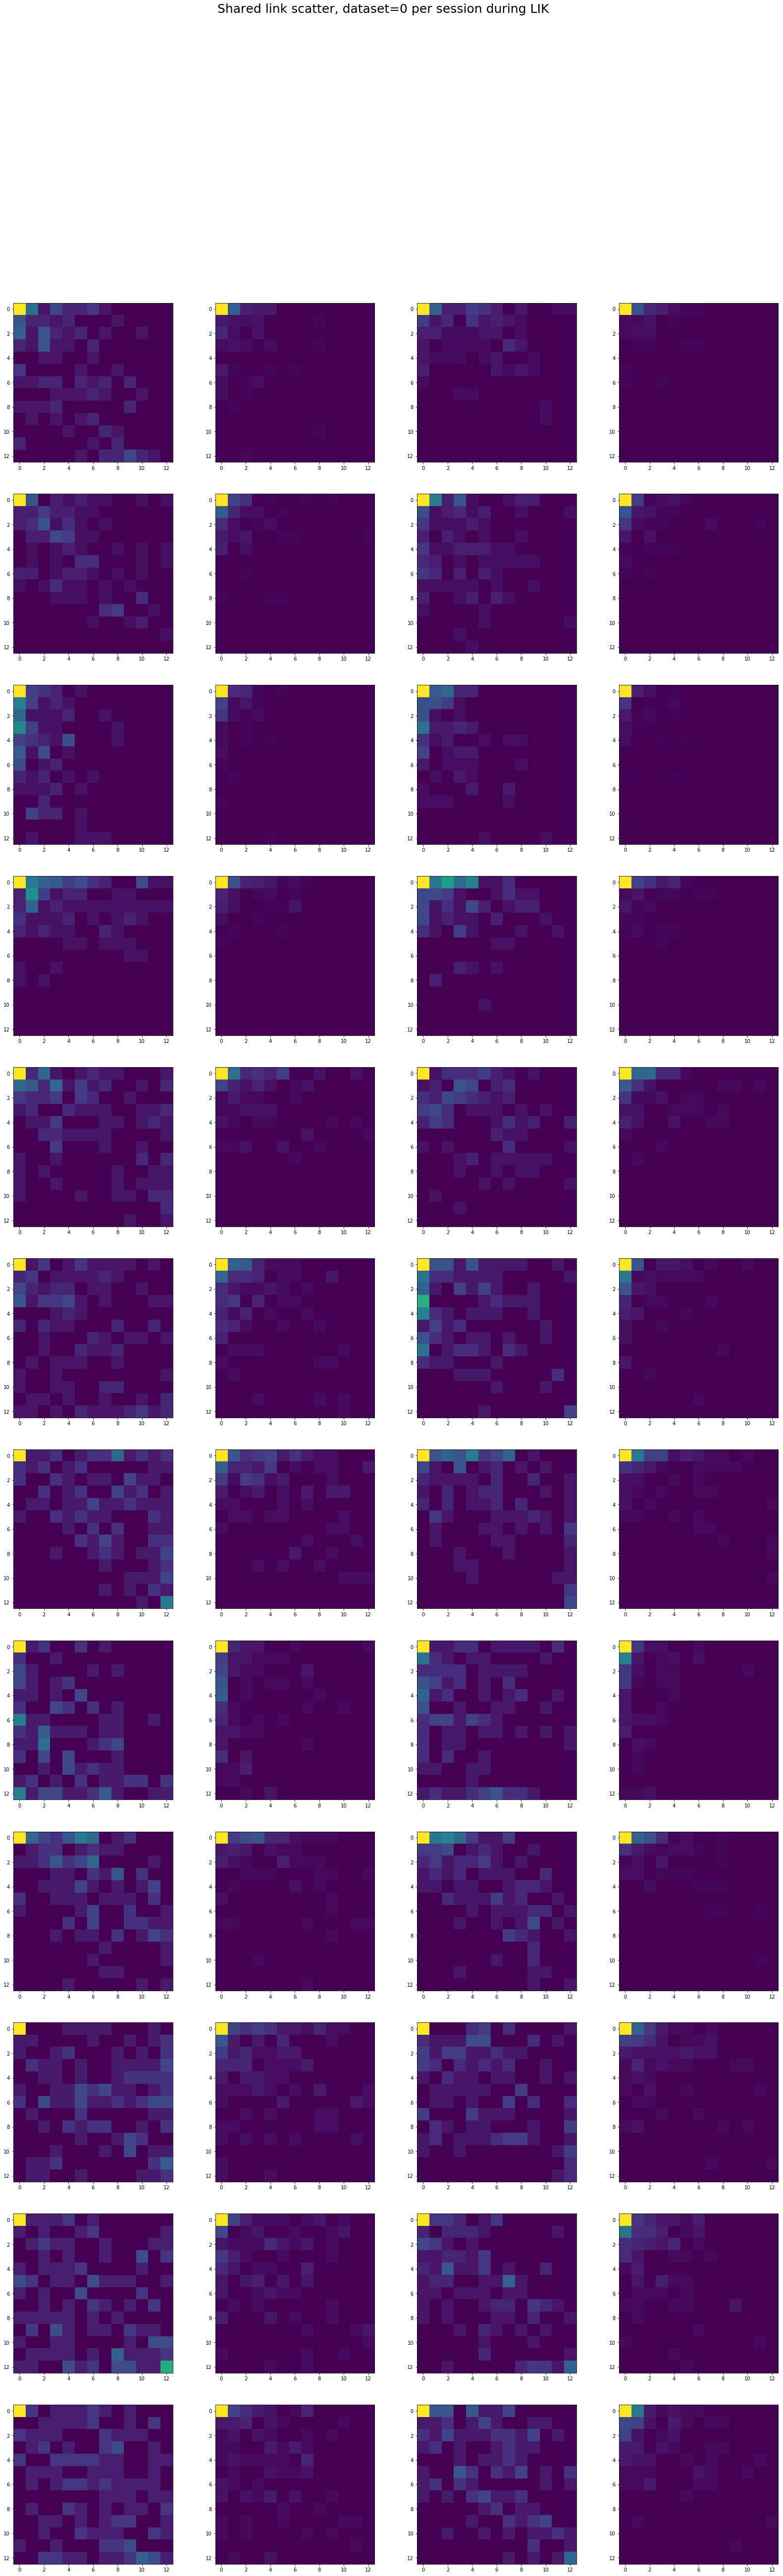

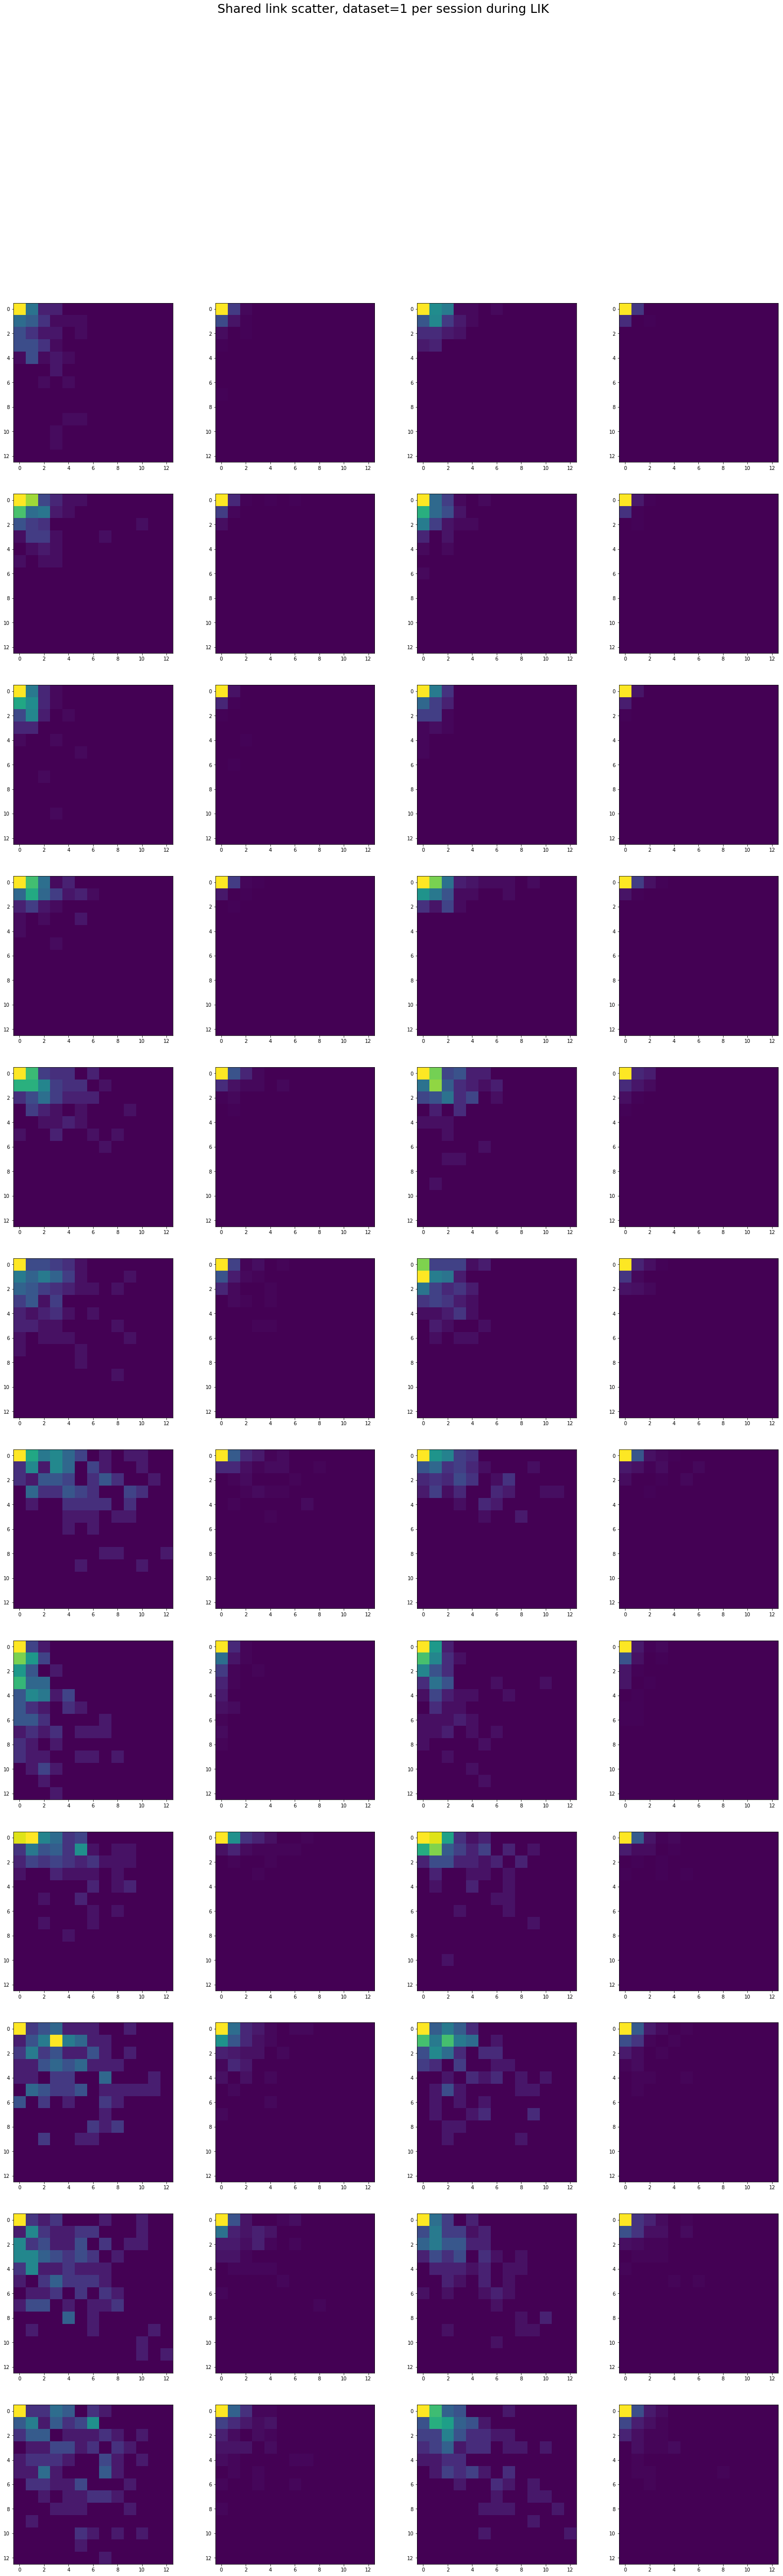

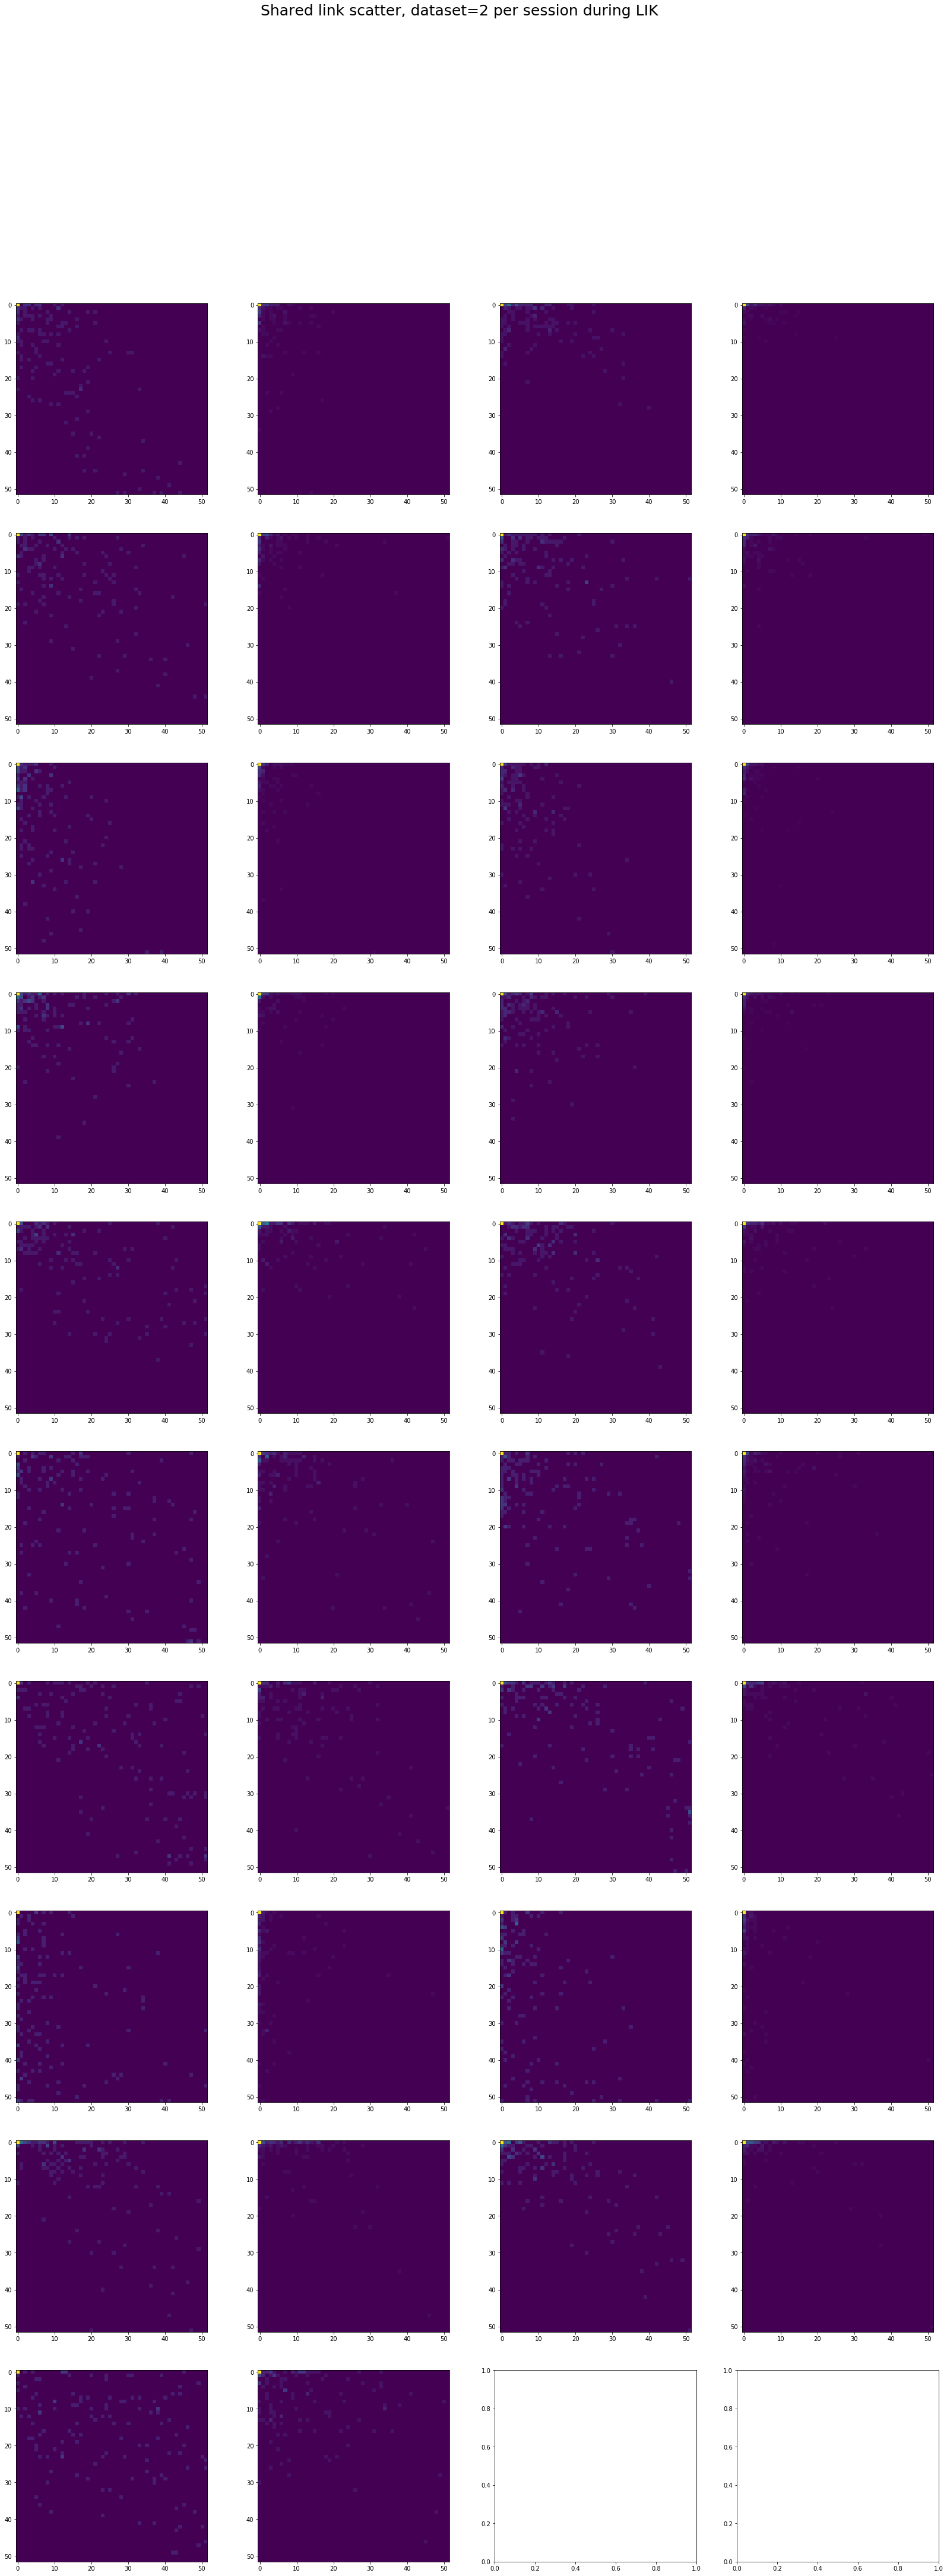

In [7]:
#################################
# Session : Shared Link Scatter
#################################
for rng_name, rng_sec in ranges_sec.items():
    for iDataSet, (basenames, stat) in enumerate(zip(basenamesets, statistics)):
        tflist = getTitlesAndIndices(stat, 'mtp_15', ["GO","NOGO"], ["BTE","MTE"], "swipe")

        nFiles = np.sum(tflist[0][1])
        fig, ax = plt.subplots(nrows=nFiles-1, ncols=nPlots, figsize=(7*nPlots, 7*(nFiles-1)))
        fig.suptitle('Shared link scatter, dataset='+str(iDataSet)+' per session during '+rng_name, fontsize=25)
        
        for idxPlot, (pTitle, idxs_ths) in enumerate(tflist):
            nConnPerRng = []
            for idxFile, (data, basename) in enumerate(zip(datasets[iDataSet][idxs_ths], basenames[idxs_ths])):
                te, lag, p = data
                
                N_TIMES = te.shape[2]
                rng = np.round((np.array(rng_sec) / 10.0 * N_TIMES)).astype(int)
                rng_len = rng[1] - rng[0] + 1

                te_rng = te[:,:,rng[0]:rng[1]]
                nConnPerRng += [np.sum(1-np.isnan(te_rng).astype(int), axis=2)]
                
            sharedConn = []
            
            nFiles = np.sum(idxs_ths)
            for idxFile in range(1, nFiles):
                M = np.zeros((rng_len, rng_len))
                for x, y in zip(nConnPerRng[idxFile-1].flatten(), nConnPerRng[idxFile].flatten()):
                    M[x][y] += 1
                ax[idxFile-1][idxPlot].imshow(M)


#totalConnPerConn[-1][-1].append(np.sum(1-np.isnan(te).astype(int), axis=2).flatten()  / (te.shape[0]**2 - te.shape[0]))
# fig2, ax2 = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
# for i, trial in enumerate(["GO","NOGO"]):#in enumerate(["ALL"]):
#     ax1[i][0].set_ylabel(trial)
#     for j, method in enumerate(["BTE","MTE"]):
        
#         ax2[i][j].set_xlabel("connection index, sorted")
#         ax2[i][j].set_ylabel("Frequency of occurence")
        
#         thisConn = np.array(totalConnPerConn[i][j])
#         sortedArgs = np.flip(np.argsort(np.sum(thisConn, axis=0)))
        
#         for conn in totalConnPerConn[i][j]:
#             ax2[i][j].plot(conn[sortedArgs], '.')

## Range Analysis

In [ ]:
isCorrectMouse = np.array([mname == 'mtp_15' for mname in mouse_names], dtype=int)

fig1, ax1 = plt.subplots(ncols=2, figsize=(10, 5))
fig2, ax2 = plt.subplots(nrows=2, ncols=3, figsize=(15, 5), tight_layout=True)

for i, trial in enumerate(["ALL"]):
    for j, method in enumerate(["BTE","MTE"]):
        ax2[j][0].set_ylabel(method)
        
        for k, rng in enumerate(["CUE", "TEX", "LIK"]):
            ax2[0][k].set_title(rng)
            
            idxs_ths = isCorrectMouse + isAnalysis["range"] + isTrial[trial] + isMethod[method] + isRange[rng] == 5
            print("For trials", trial,"range", rng,"method", method, "have", np.sum(idxs_ths), "files")
            
            nConn = []
            actSum = np.zeros((12,12))
            for fname, basename in zip(datafilenames[idxs_ths], basenames[idxs_ths]):
#                 print("Processing file: ", basename)
                te, lag, p = getData(fname)

                isActive = 1-np.isnan(te).astype(int)
                actSum += isActive
                nConn += [np.sum(isActive) / (te.shape[0]**2 - te.shape[0])]
#                 totalConnPerConn[-1][-1].append(np.sum(1-np.isnan(te).astype(int), axis=2).flatten()  / (te.shape[0]**2 - te.shape[0]))

            ax1[j].plot(nConn, label=rng)
            ax2[j][k].imshow(actSum)
    
        ax1[j].set_title(method)
        ax1[j].set_xlabel("day/file")
        ax1[j].set_ylabel("ratio of active connections")
        ax1[j].legend()        

In [ ]:
# for model in ["BivariateTE", "MultivariateTE"]:
#     for i in range(16, 20):
#         for rng in ["CUE", "TEX", "LIK"]:
#             fname = "mtp_15_2018_05_" + str(i) + "_a_" + model + "_range_" + rng + ".h5"
#             te, lag, p = getData(fname)
            
#             fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))
#             ax[0].imshow(te[:,:], cmap="jet", vmin=0, vmax=1)
#             ax[1].imshow(lag[:,:], cmap="jet", vmin=1, vmax=5)
#             ax[2].imshow(p[:,:], cmap="jet", vmin=0, vmax=1)
#             ax[0].set_title("TE")
#             ax[1].set_title("delay")
#             ax[2].set_title("p-value")
            
#             fig.suptitle(fname)
#             plt.show()

## Processing swipe Data

In [ ]:
bte_te, bte_lag, bte_p = getData("mtp_15_2018_05_19_a_BivariateTE_swipe.h5")
mte_te, mte_lag, mte_p = getData("mtp_15_2018_05_19_a_MultivariateTE_swipe.h5")

# Interactive
def f(i):
    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 8))
    ax[0][0].imshow(bte_te[:,:,i], cmap="jet", vmin=0, vmax=1)
    ax[1][0].imshow(mte_te[:,:,i], cmap="jet", vmin=0, vmax=1)
    ax[0][1].imshow(bte_lag[:,:,i], cmap="jet", vmin=1, vmax=5)
    ax[1][1].imshow(mte_lag[:,:,i], cmap="jet", vmin=1, vmax=5)
    ax[0][2].imshow(bte_p[:,:,i], cmap="jet", vmin=0, vmax=1)
    ax[1][2].imshow(mte_p[:,:,i], cmap="jet", vmin=0, vmax=1)
    
    ax[0][0].set_ylabel("Bivariate")
    ax[1][0].set_ylabel("Multivatiate")
    ax[0][0].set_title("TE")
    ax[0][1].set_title("delay")
    ax[0][2].set_title("p-value")
    plt.show()
    
interactive_plot = interactive(f, i=(0, bte_te.shape[2]-1, 1))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot